In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [158]:
# load df
df1 = pd.read_csv('data.csv')
df2 = pd.read_csv('data2.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
filter_date = pd.to_datetime('2019-11-01')
df2 =  df2[df2['Date'] > filter_date]
df = pd.concat([df1,df2], ignore_index=True)
df = df.sort_values(by='Date')
df.drop_duplicates(subset=['Date'])
df = df.set_index("Date")

In [159]:
# numeric preprocessing
# convert to float
def convert_to_float_locale(val):
    if isinstance(val, str):
        return locale.atof(val.replace(',', ''))
    return val 

df['Price'] = df['Price'].apply(convert_to_float_locale)
df['Open'] = df['Open'].apply(convert_to_float_locale)
df['High'] = df['High'].apply(convert_to_float_locale)
df['Low'] = df['Low'].apply(convert_to_float_locale)

def change_percent(percentage_str):
    return float(percentage_str.strip('%')) / 100
def change_vol(value_str):
    value_str = str(value_str)
    if value_str.endswith('K'):
        value = float(value_str[:-1]) * 1_000
    elif value_str.endswith('M'):
        value = float(value_str[:-1]) * 1_000_000
    elif value_str.endswith('B'):
        value = float(value_str[:-1]) * 1_000_000_000
    else:
        value = float(value_str)
    return value

df['Change %'] = df['Change %'].apply(change_percent)
df['Vol.'] = df['Vol.'].apply(change_vol)

<Axes: xlabel='Date'>

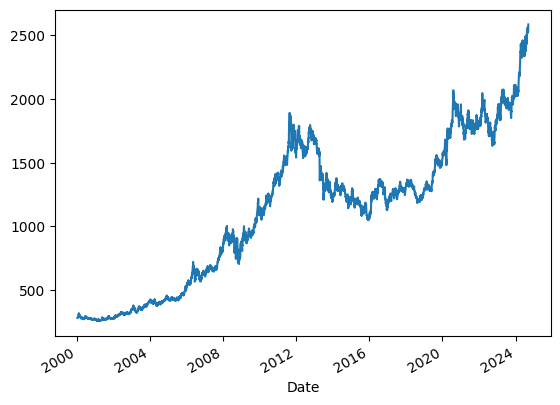

In [160]:
# plot df
df['Price'].plot()

In [233]:
# calculate indicators SMA (for 3, 5, 7, 14 days), RSI, MACD, CCI, ADX, RSI Change, ATR
def calculate_SMA(df, days):
    return df['Price'].rolling(window=days).mean()

def calculate_RSI(df, days):
    delta = df['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=days).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=days).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def calculate_MACD(df, short_window, long_window):
    short_ema = df['Price'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Price'].ewm(span=long_window, adjust=False).mean()
    return short_ema - long_ema

def calculate_CCI(df, days):
    TP = (df['High'] + df['Low'] + df['Price']) / 3
    SMA = TP.rolling(window=days).mean()
    MAD = (TP - SMA).abs().rolling(window=days).mean()
    return (TP - SMA) / (0.015 * MAD)

def calculate_ADX(df, days):
    TR = pd.DataFrame(index=df.index)
    TR['HL'] = df['High'] - df['Low']
    TR['HC'] = (df['High'] - df['Price'].shift(1)).abs()
    TR['LC'] = (df['Low'] - df['Price'].shift(1)).abs()
    TR['TR'] = TR[['HL', 'HC', 'LC']].max(axis=1)
    TR['ATR'] = TR['TR'].rolling(window=days).mean()
    TR['+DM'] = (df['High'] - df['High'].shift(1)).where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 0)
    TR['-DM'] = (df['Low'].shift(1) - df['Low']).where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 0)
    TR['+DI'] = (TR['+DM'] / TR['ATR']).rolling(window=days).mean()
    TR['-DI'] = (TR['-DM'] / TR['ATR']).rolling(window=days).mean()
    TR['DX'] = (TR['+DI'] - TR['-DI']).abs() / (TR['+DI'] + TR['-DI'])
    return TR['DX'].rolling(window=days).mean()

def calculate_RSI_Change(df, days):
    return df['RSI14'].diff(periods=days)

def calculate_ATR(df, days):
    TR = pd.DataFrame(index=df.index)
    TR['HL'] = df['High'] - df['Low']
    TR['HC'] = (df['High'] - df['Price'].shift(1)).abs()
    TR['LC'] = (df['Low'] - df['Price'].shift(1)).abs()
    TR['TR'] = TR[['HL', 'HC', 'LC']].max(axis=1)
    return TR['TR'].rolling(window=days).mean()

df['SMA3'] = calculate_SMA(df, 3)
df['SMA5'] = calculate_SMA(df, 5)
df['SMA7'] = calculate_SMA(df, 7)
df['SMA14'] = calculate_SMA(df, 14)
df['RSI14'] = calculate_RSI(df, 14)
df['MACD'] = calculate_MACD(df, 12, 26)
df['CCI'] = calculate_CCI(df, 20)
df['ADX'] = calculate_ADX(df, 14)
df['RSI_Change'] = calculate_RSI_Change(df, 1)
df['ATR'] = calculate_ATR(df, 14)

In [234]:
# preprocess data
# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the DataFrame
df_standardized = pd.DataFrame(scaler.fit_transform(df.drop("Change %", axis =1)), columns=[col for col in df.columns if col !='Change %'])


# create target column    
df_standardized['Target'] = list(df.shift(-1)['Change %'] * 100) 

def get_label(val):
    if val < 0:
        return 0
    else:
        return 1
    
df_standardized['Target'] = df_standardized['Target'].apply(get_label)
df_standardized = df_standardized.dropna()
df_standardized

,Price,Open,High,Low,Vol.,SMA3,SMA7,SMA14,RSI14,MACD,CCI,ADX,RSI_Change,SMA5,ATR,Target
39,-1.455651,-1.462815,-1.457364,-1.458190,-0.809420,-1.460893,-1.460589,-1.453398,-1.171932,-0.262187,-0.767457,0.529116,2.346302,-1.461347,-1.150785,0
40,-1.461404,-1.455320,-1.458056,-1.457488,-0.843419,-1.460835,-1.461537,-1.455223,-1.474867,-0.284547,-0.820400,0.198422,-0.771429,-1.462360,-1.157847,1
41,-1.457395,-1.461943,-1.461519,-1.457839,-0.687069,-1.458916,-1.461912,-1.456610,-1.126502,-0.287321,-0.783923,-0.017252,0.886838,-1.461312,-1.216277,0
42,-1.462101,-1.457237,-1.459788,-1.458190,-0.893030,-1.461067,-1.462735,-1.458773,-1.703735,-0.304292,-0.788977,-0.230737,-1.469815,-1.461417,-1.223982,1
43,-1.459486,-1.461943,-1.461692,-1.457136,-0.913499,-1.460428,-1.462286,-1.460798,-1.558205,-0.307350,-0.706732,-0.431982,0.370403,-1.460684,-1.238749,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6248,2.465414,2.435920,2.452510,2.464707,0.689433,2.445528,2.462660,2.471323,0.485895,1.498812,0.196777,-0.701438,0.112933,2.456396,1.389279,0
6249,2.433165,2.471999,2.462551,2.447500,1.561499,2.446458,2.455600,2.469673,-0.350004,1.331497,-0.011265,-0.764183,-2.128402,2.443934,1.298104,1
6250,2.447285,2.436094,2.422216,2.448027,0.549157,2.450354,2.454328,2.468598,-0.280835,1.231045,-0.153411,-0.786810,0.175980,2.445714,1.273062,1
6251,2.465414,2.452652,2.441258,2.473837,0.728751,2.450354,2.450037,2.467661,-0.264751,1.197728,0.030321,-0.765496,0.040822,2.452731,1.165835,0


In [235]:
# create custom dataset
class FuturesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create pytorch model
class FuturesModel(nn.Module):
    def __init__(self, input_dim):
        super(FuturesModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),                 
            nn.Linear(64, 32),         
            nn.ReLU(),                 
            nn.Linear(32, 1),          
            nn.Sigmoid()               
        )

    def forward(self, x):
        return self.model(x)

In [236]:
# split data into features and target
train_len = int(0.6 * len(df_standardized))
X, y = df_standardized.drop('Target', axis=1)[:train_len].values, df_standardized['Target'][:train_len].values

In [237]:
# Initialize the time series splitter
tscv = TimeSeriesSplit(n_splits=5)

train_losses = []
val_losses = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f'Fold {fold + 1}')
    
    # Create train and test sets based on the fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert them into PyTorch tensors and create DataLoaders
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Reinitialize the model for each fold
    model = FuturesModel(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model on this fold
    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # Track loss over the epoch
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  # Accumulate batch loss

        avg_train_loss = running_loss / len(train_dataloader)  # Average loss for the epoch
        train_losses.append(avg_train_loss)  # Store average epoch loss

        # Evaluate on validation data
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()  # Accumulate validation loss
                
                # Convert probabilities to binary predictions (threshold = 0.5)
                predicted = (outputs >= 0.5).int()  # Predictions as 0 or 1
                correct += (predicted == targets.int()).sum().item()  # Count correct predictions
                total += targets.size(0)  # Total number of predictions

        avg_val_loss = val_loss / len(test_dataloader)  # Average validation loss per batch
        val_losses.append(avg_val_loss)  # Store validation loss for the fold
        
        # Calculate accuracy
        accuracy = correct / total
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Accuracy: {accuracy * 100:.2f}%')

Fold 1
Epoch 1, Training Loss: 0.695456200838089, Validation Loss: 0.6953001320362091, Accuracy: 47.90%
Epoch 2, Training Loss: 0.6893000125885009, Validation Loss: 0.6917150676250458, Accuracy: 53.06%
Epoch 3, Training Loss: 0.688871192932129, Validation Loss: 0.6923023879528045, Accuracy: 53.87%
Epoch 4, Training Loss: 0.6873080372810364, Validation Loss: 0.6924098163843155, Accuracy: 54.35%
Epoch 5, Training Loss: 0.6865443050861358, Validation Loss: 0.693294820189476, Accuracy: 53.55%
Epoch 6, Training Loss: 0.6851584732532501, Validation Loss: 0.6934722155332566, Accuracy: 53.87%
Epoch 7, Training Loss: 0.6845334291458129, Validation Loss: 0.6942106723785401, Accuracy: 53.39%
Epoch 8, Training Loss: 0.6834026336669922, Validation Loss: 0.694649600982666, Accuracy: 53.06%
Epoch 9, Training Loss: 0.6825878143310546, Validation Loss: 0.6953103691339493, Accuracy: 53.23%
Epoch 10, Training Loss: 0.6814926952123642, Validation Loss: 0.695748245716095, Accuracy: 53.06%
Epoch 11, Trainin

In [238]:
split = 0.6
split_index = int(len(df_standardized) * split)
X, y = df_standardized.drop('Target', axis=1).values, df_standardized['Target'].values

# convert to tensors
X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Calculate accuracy on training set
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_predictions = (train_outputs >= 0.5).int()  # Assuming binary classification
    train_accuracy = (train_predictions == y_train).float().mean().item()
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculate accuracy on test/validation set
    val_outputs = model(X_test)
    val_predictions = (val_outputs >= 0.5).int()
    val_accuracy = (val_predictions == y_test).float().mean().item()
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


Training Accuracy: 60.04%
Validation Accuracy: 51.27%


In [239]:
y_preds = []
for pred in val_outputs:
    y_preds.append(0 if pred < 0.5 else 1)
y_pred = y_preds

In [240]:
combo_results = []
for j in range(1,100):
    threshold = float(j/100)
    results = []
    y_test = list(y_test)
    y_pred = list(y_pred)
    for i in range(len(list(y_test))):
        if y_pred[i] == 1 and val_outputs[i] > threshold:
            results.append(y_pred[i] == y_test[i])
        elif y_pred[i] == 0 and 1-val_outputs[i] > threshold:
            results.append(y_pred[i] == y_test[i])
    if results:
        combo_results.append({j:(sum(results)/len(results), len(results))})

In [241]:
vals = [list(combo.values())[0][0] for combo in combo_results]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.47      0.28      0.35      1169
         1.0       0.53      0.72      0.61      1312

    accuracy                           0.51      2481
   macro avg       0.50      0.50      0.48      2481
weighted avg       0.50      0.51      0.49      2481



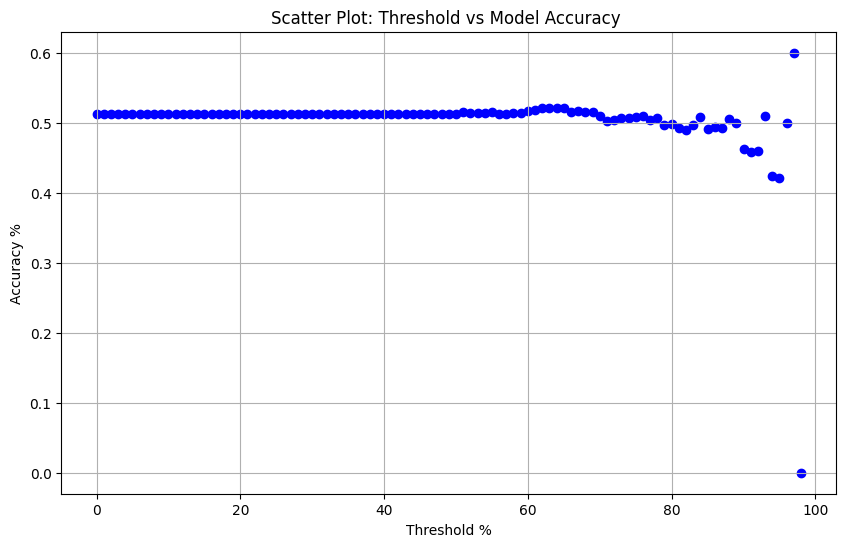

In [245]:
# Assuming df is loaded and has the required columns for plotting

# Creating a scatter plot for df['Change_SMA_3'] vs df['Change %']
plt.figure(figsize=(10, 6))
plt.scatter(list(range(len(vals))), vals, color='b')
plt.xlabel('Threshold %')
plt.ylabel('Accuracy %')
plt.title('Scatter Plot: Threshold vs Model Accuracy ')
plt.grid(True)
plt.show()

In [287]:
class FuturesBacktester:
    def __init__(self, df, confidence_threshold=0.8, exit_threshold=0.5, cash_account=100000, margin_account=0, 
                 initial_margin_rate=0.2, maintenance_margin_rate=0.1, interest_rate_cash=0.036, interest_rate_margin=0.02):
        self.backtest_df = df
        self.confidence_threshold = confidence_threshold
        self.exit_threshold = exit_threshold
        self.cash_account = cash_account
        self.margin_account = margin_account
        self.initial_margin_rate = initial_margin_rate
        self.maintenance_margin_rate = maintenance_margin_rate
        self.interest_rate_cash = interest_rate_cash
        self.interest_rate_margin = interest_rate_margin
        self.in_position = False
        self.position_value = 0
        self.num_contracts = 0  # Track the number of contracts bought
        self.pos = 0
        self.neg = 0
        self.pos_trades = 0
        self.neg_trades = 0
        self.max_pos = float('-inf')
        self.max_neg = float('inf')
        self.num_trades = 0
        self.position_type = None
        self.initial_future_value = 0

        # Arrays to track portfolio value and risk-free value over time
        self.dates = []
        self.portfolio_values = []
        self.risk_free_values = []
        self.benchmark_values = []
        self.initial_cash_account = cash_account  # Save the initial cash account for risk-free growth

    def run_backtest(self):
        for index, data in self.backtest_df.iterrows():
            # Apply interest rates
            self.cash_account = self.cash_account * (1 + self.interest_rate_cash / 252)
            self.margin_account = self.margin_account * (1 + self.interest_rate_margin / 252)

            # Risk-free account (compounding interest on the initial cash account)
            risk_free_value = self.initial_cash_account * (1 + self.interest_rate_cash / 252)**(index + 1)

            # Store the date and current portfolio value (cash + margin)
            self.dates.append(data['Date'])  # Assuming 'index' is the date column, adjust if necessary
            portfolio_value = self.cash_account + self.margin_account
            self.portfolio_values.append(portfolio_value)
            self.risk_free_values.append(risk_free_value)
            self.benchmark_values.append(data['Price'] * (self.initial_cash_account / self.backtest_df['Price'].iloc[0]))

            # if in position, mark to market
            if self.in_position:
                self._mark_to_market(data, index)

            # Try to open a new position if not already in one
            if not self.in_position:
                if data['Confidence'] >= self.confidence_threshold:
                    self.open_position(data, index, position_type="long")
                elif data['Confidence'] <= (1 - self.confidence_threshold):  # Shorting when confidence is low
                    self.open_position(data, index, position_type="short")

            # Exit the position if confidence falls below the exit threshold
            elif self.in_position and (
                (self.position_type == "long" and data['Confidence'] < self.exit_threshold) or
                (self.position_type == "short" and data['Confidence'] > (1 - self.exit_threshold))
            ):
                self._exit_position(data, index)

            # If still in position at the end of the backtest
            if self.in_position and index == len(self.backtest_df) - 1:
                self._exit_position(data, index)

    def _mark_to_market(self, data, index):
        price = data['Price']
        if self.position_type == "long":
            unrealized_pl = (price - self.position_value) * self.num_contracts
        elif self.position_type == "short":
            unrealized_pl = (self.position_value - price) * self.num_contracts
        
        # Stop-loss (risk 2% of the account per trade, e.g., stop if loss > 2%)
        stop_loss_level = self.position_value * 0.98
        if price <= stop_loss_level:
            self._exit_position(data, index)
            self.neg += 1
            return

        # Take-profit (e.g., take profit at 2:1 reward to risk ratio)
        take_profit_level = self.position_value * 1.04  # Reward is 4% gain
        if price >= take_profit_level:
            self.pos += 1
            self._exit_position(data, index)
            return

        # Calculate the required margin based on the current value of the position
        total_contract_value = self.num_contracts * price
        required_margin = total_contract_value * self.initial_margin_rate

        # Handle profit
        if unrealized_pl > 0:
            # Calculate excess profit (amount above the required margin)
            self.pos += 1
            excess_profit = self.margin_account + unrealized_pl - required_margin
                        
            if excess_profit > 0:
                # Move excess profit to cash account
                self.cash_account += excess_profit
                self.margin_account = required_margin
            else:
                # If no excess profit, just adjust margin account
                self.margin_account += unrealized_pl
        else:
            # Handle loss: if margin account is insufficient, deduct from cash account
            self.neg += 1
            loss_to_cover = required_margin - (self.margin_account + unrealized_pl)
            if loss_to_cover > 0:
                if self.cash_account >= loss_to_cover:
                    self.cash_account -= loss_to_cover
                    self.margin_account = required_margin
                else:
                    # If not enough cash to cover the loss, exit the position
                    print(f"Margin call failed on day {index}. Insufficient cash to cover the loss.")
                    self._exit_position(data, index)
                    return
            else:
                # If no need to cover with cash, just adjust margin account
                self.margin_account += unrealized_pl

        # Update the position value to the current price
        self.position_value = price

    def open_position(self, data, index, position_type="long"):
        """
        Attempts to open a new position (long or short) by investing 50% of the current cash account.
        Calculates the number of contracts to buy/sell based on the current price.
        """
        self.in_position = True
        self.position_type = position_type
        price = data['Price']
        self.initial_future_value = price

        # Invest 50% of the cash account
        cash_to_invest = self.cash_account * 0.5

        # Calculate how many contracts you can buy with this cash
        self.num_contracts = cash_to_invest // price

        # Total value of the contracts
        total_contract_value = self.num_contracts * price

        # Margin requirement is a percentage of the total value of the contracts
        margin_requirement = total_contract_value * self.initial_margin_rate

        if self.cash_account >= margin_requirement:
            # Deduct only the margin requirement from the cash account
            self.cash_account -= margin_requirement
            self.margin_account += margin_requirement
            self.position_value = price  # The price at which the position was opened
        else:
            print(f'Not enough cash to cover margin on day {index}, skipping trade')
            self.in_position = False

        self.num_trades += 1

    def _exit_position(self, data, index):
        """
        Exits the current position, calculates profit or loss, and returns margin and profit to the cash account.
        Handles both long and short positions.
        """
        price = data['Price']
        if price > self.initial_future_value:
            self.pos_trades += 1
        else:
            self.neg_trades += 1

        # Reset margin and contract counts
        self.in_position = False
        self.cash_account += self.margin_account
        self.margin_account = 0
        self.num_contracts = 0
        self.position_type = None

    def plot(self):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.plot(self.dates, self.portfolio_values, label="Strategy")
        plt.plot(self.dates, self.risk_free_values, label="Risk-Free Investment")
        plt.plot(self.dates, self.benchmark_values, label="Benchmark")
        plt.xlabel("Date")
        plt.ylabel("Value ($)")
        plt.title("Portfolio Value Over Time")
        plt.legend()
        plt.show()

    def report(self):
        print(f'Diff between portfolio and risk-free value: {self.portfolio_values[-1] - self.risk_free_values[-1]}')
        print(f'Number of days profited: {self.pos}')
        print(f'Number of days lost: {self.neg}')
        print(f'Total trades: {self.num_trades}')
        print(f'Total positive trades: {self.pos_trades}')
        print(f'Total negative trades: {self.neg_trades}')
        print(f'Final cash account: {self.cash_account}')
        print(f'Final margin account: {self.margin_account}')

Diff between portfolio and risk-free value: 45619.796947633324
Number of days profited: 945
Number of days lost: 928
Total trades: 241
Total positive trades: 124
Total negative trades: 117
Final cash account: 187590.85118986527
Final margin account: 0


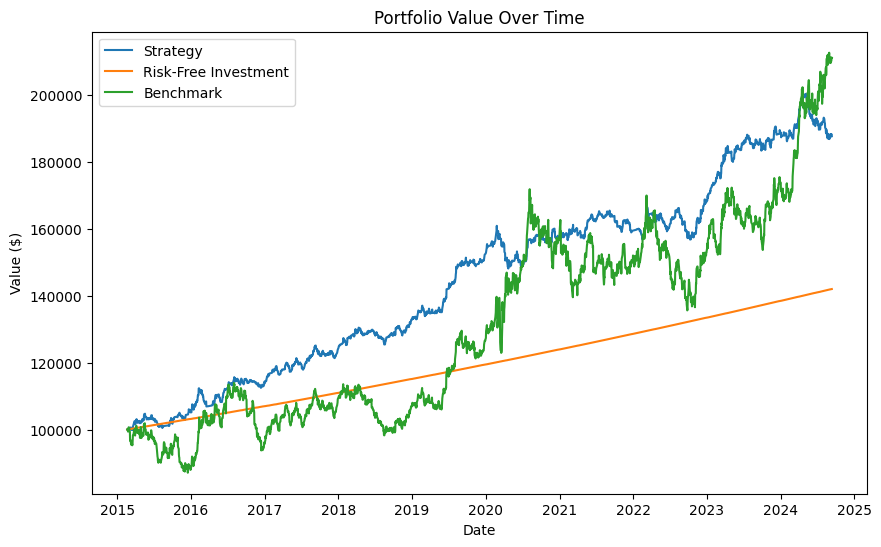

In [302]:
# run backtest
model_outputs = torch.cat((train_outputs, val_outputs), 0)
model_outputs = model_outputs.squeeze().tolist()
backtest_df = pd.DataFrame(df.drop("Change %", axis =1), columns=[col for col in df.columns if col !='Change %']).dropna()
backtest_df['Confidence'] = model_outputs
backtest_df = backtest_df[['Price', 'Confidence', 'ATR']][3750:]
backtest_df = backtest_df.reset_index()

backtester = FuturesBacktester(backtest_df, confidence_threshold=0.7)
backtester.run_backtest()
backtester.report()
backtester.plot()